In [1]:
import pandas as pd

In [2]:
data=pd.read_csv(r"C:\Users\admin\Desktop\Data Science\Time Series Analysis\Time Series Analysis\dataset1.csv")

In [6]:
data=data[["Wind Speed"]]
data

,Wind Speed
0,1.3
1,1.2
2,1.2
3,1.2
4,1.2
...,...
52555,1.3
52556,1.3
52557,1.3
52558,1.3


<Axes: >

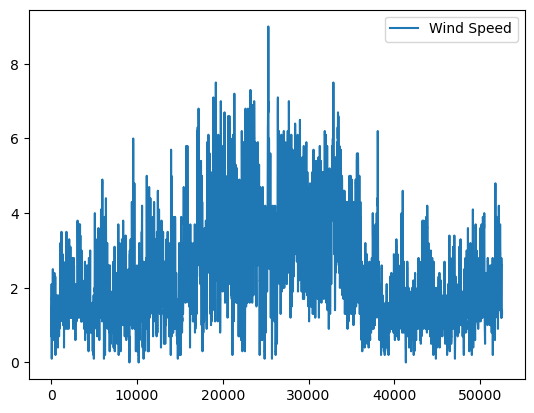

In [5]:
data.plot()

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import numpy as np

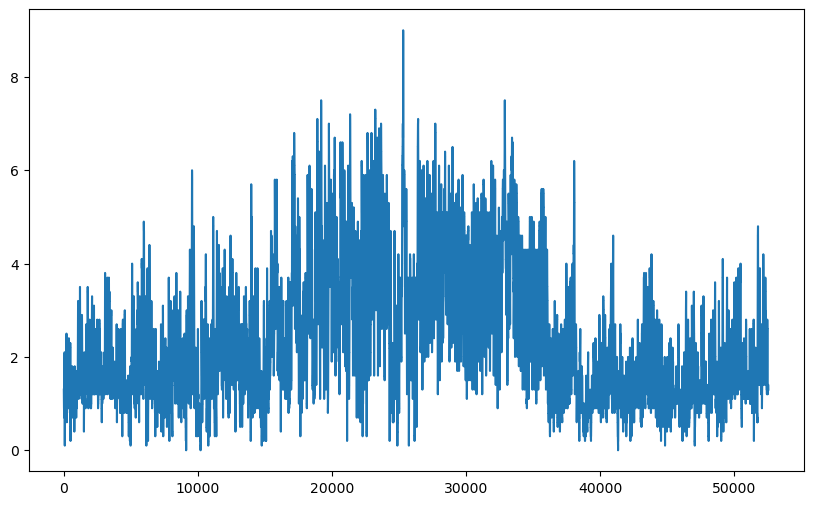

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10,6)})
plt.plot(data['Wind Speed'])

Text(0.5, 0.98, 'Additive Decompose')

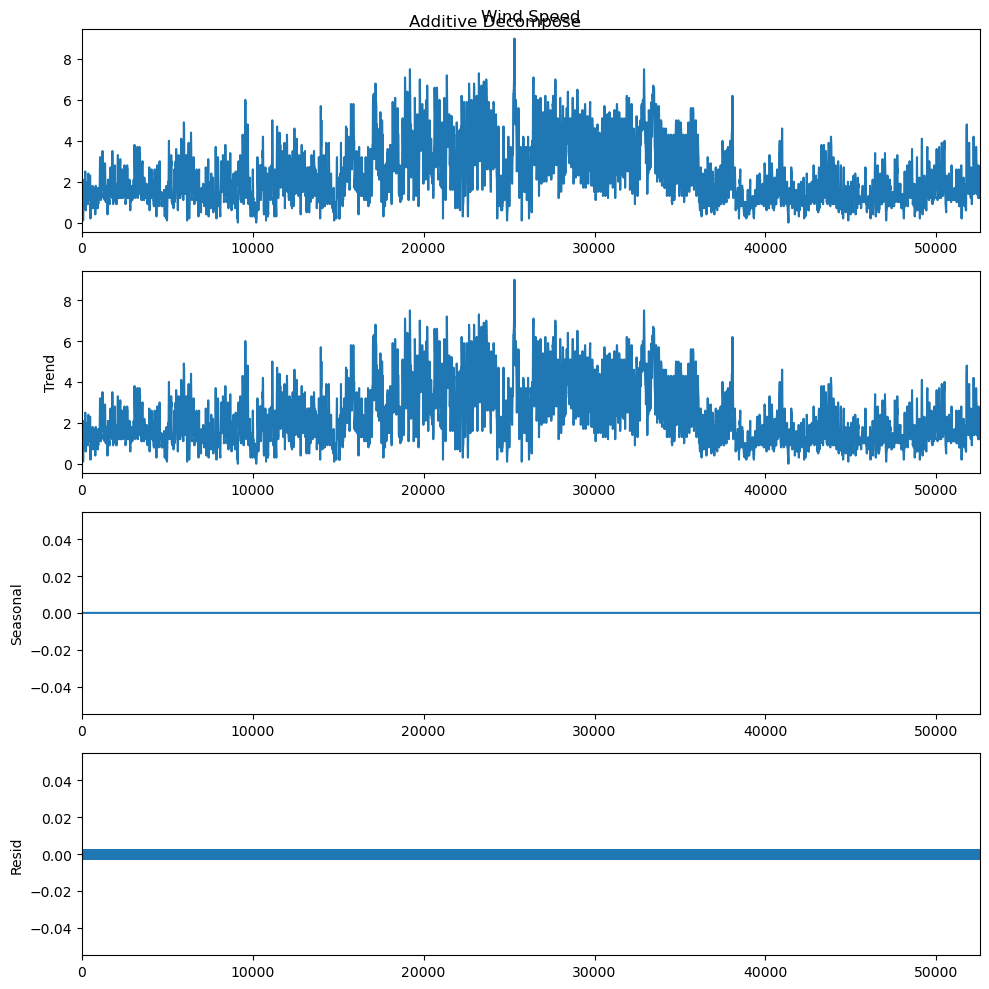

In [17]:

# Additive Decomposition
add_result = seasonal_decompose(data['Wind Speed'], model='additive',period=1)
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
add_result.plot().suptitle('Additive Decompose', fontsize=12)


In [18]:
# Multiplicative Decomposition 
mul_result = seasonal_decompose(data['Wind Speed'], model='multiplicative',period=1)
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
mul_result.plot().suptitle('Additive Decompose', fontsize=12)



ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [7]:
data

,Wind Speed
0,1.3
1,1.2
2,1.2
3,1.2
4,1.2
...,...
52555,1.3
52556,1.3
52557,1.3
52558,1.3


In [20]:
data=data.rename(columns={"Wind Speed":"windspeed"})

In [21]:
from statsmodels.tsa.stattools import adfuller

H0:data is not stationary
H1:data is stionary

In [22]:
data

,windspeed
0,1.3
1,1.2
2,1.2
3,1.2
4,1.2
...,...
52555,1.3
52556,1.3
52557,1.3
52558,1.3


In [23]:
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(data.windspeed.values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.484789780638199
p-value: 6.286894364308886e-27
Critial Values:
   1%, -3.4304745523232394
Critial Values:
   5%, -2.8615950496267875
Critial Values:
   10%, -2.5667993010856045


In [27]:
p_value=adfuller_result[1]
p_value

6.286894364308886e-27

In [32]:
data

,windspeed
0,1.3
1,1.2
2,1.2
3,1.2
4,1.2
...,...
52555,1.3
52556,1.3
52557,1.3
52558,1.3


# LSTM without EMD

In [4]:
data["Wind Speed"]

0        1.3
1        1.2
2        1.2
3        1.2
4        1.2
        ... 
52555    1.3
52556    1.3
52557    1.3
52558    1.3
52559    1.3
Name: Wind Speed, Length: 52560, dtype: float64

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Generate some dummy data
data = np.random.randn(100, 10)  # 100 timesteps, 10 features

# Split the data into input and output
X = data[:-1]  # Input sequence
y = data[1:]   # Output sequence shifted by one timestep

# Reshape input data for LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, timesteps, features)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[2]))  # Output layer with the same number of features as input

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=100, batch_size=32, verbose=2)

# Make predictions
predictions = model.predict(X)
print(predictions.shape)  # Should be the same shape as y


IndexError: tuple index out of range

In [ ]:
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Generate a sample signal
t = np.linspace(0, 1, 8760)
signal = TS["wind speed at 80m (m/s)"].values
signal = np.reshape(signal, (8760,))

# Perform Empirical Mode Decomposition
emd = EMD()
emd.emd(signal)

# Get the IMFs and Residual
imfs, res = emd.get_imfs_and_residue()

# Normalize each IMF separately
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(len(imfs))]
imfs_normalized = [scaler.fit_transform(imf.reshape(-1, 1)).flatten() for imf, scaler in zip(imfs, scalers)]

# Set the number of time steps for the LSTM
time_steps = 10

# Prepare the data for LSTM
def create_lstm_dataset(data, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_steps):
        a = data[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(data[i + time_steps, :])
    return np.array(dataX), np.array(dataY)

# Create LSTM model for each IMF
models = []
for imf_normalized in imfs_normalized:
    X, y = create_lstm_dataset(imf_normalized.reshape(-1, 1), time_steps)
    X = np.reshape(X, (X.shape[0], time_steps, 1))
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, batch_size=32, verbose=1)
    
    models.append(model)

# Make predictions for each IMF
predicted_values = [model.predict(X) for model, X in zip(models, X)]

# Inverse transform the predictions to get the original scale
predicted_values_original_scale = [scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred, scaler in zip(predicted_values, scalers)]

# Plot the original signal, IMFs, Residual, and LSTM predictions for each IMF

plt.figure(figsize=(25, 30))

# Original Signal
plt.subplot(len(imfs) + 3, 1, 1)
plt.plot(signal, label='Original Signal')
plt.title('Original Signal')

# IMFs
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs) + 3, 1, i + 2)
    plt.plot(imf, label=f'IMF {i + 1}')
    plt.title(f'IMF {i + 1}')

# Residual Component
plt.subplot(len(imfs) + 3, 1, len(imfs) + 2)
plt.plot(res, label='Residual Component', color='red')
plt.title('Residual Component')



In [44]:
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


# Generate some random data for demonstration
np.random.seed(0)
data = np.random.rand(100, 10)  # 100 samples, 10 features

# Split data into input and target
X = data[:, :-1]  # Input features
y = data[:, -1]   # Target variable

# Reshape input data for LSTM
X = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape to (samples, time steps, features)

# Define the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2])),  # 50 LSTM units
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Using mean squared error loss and Adam optimizer

# Train the model
model.fit(X, y, epochs=100, batch_size=32)  # Train for 100 epochs with a batch size of 32

# Make predictions
predictions = model.predict(X)

# Print sample predictions
print(predictions[:5])


ModuleNotFoundError: No module named 'tensorflow.compat'

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# EMD

In [19]:
data = data.values
data

array([[1.3],
       [1.2],
       [1.2],
       ...,
       [1.3],
       [1.3],
       [1.3]])

In [20]:
data=np.reshape(data,(52560,))

In [21]:
data.shape

(52560,)

In [22]:
t = np.linspace(0, 1,52560)

In [23]:
t.shape

(52560,)

1.5.2


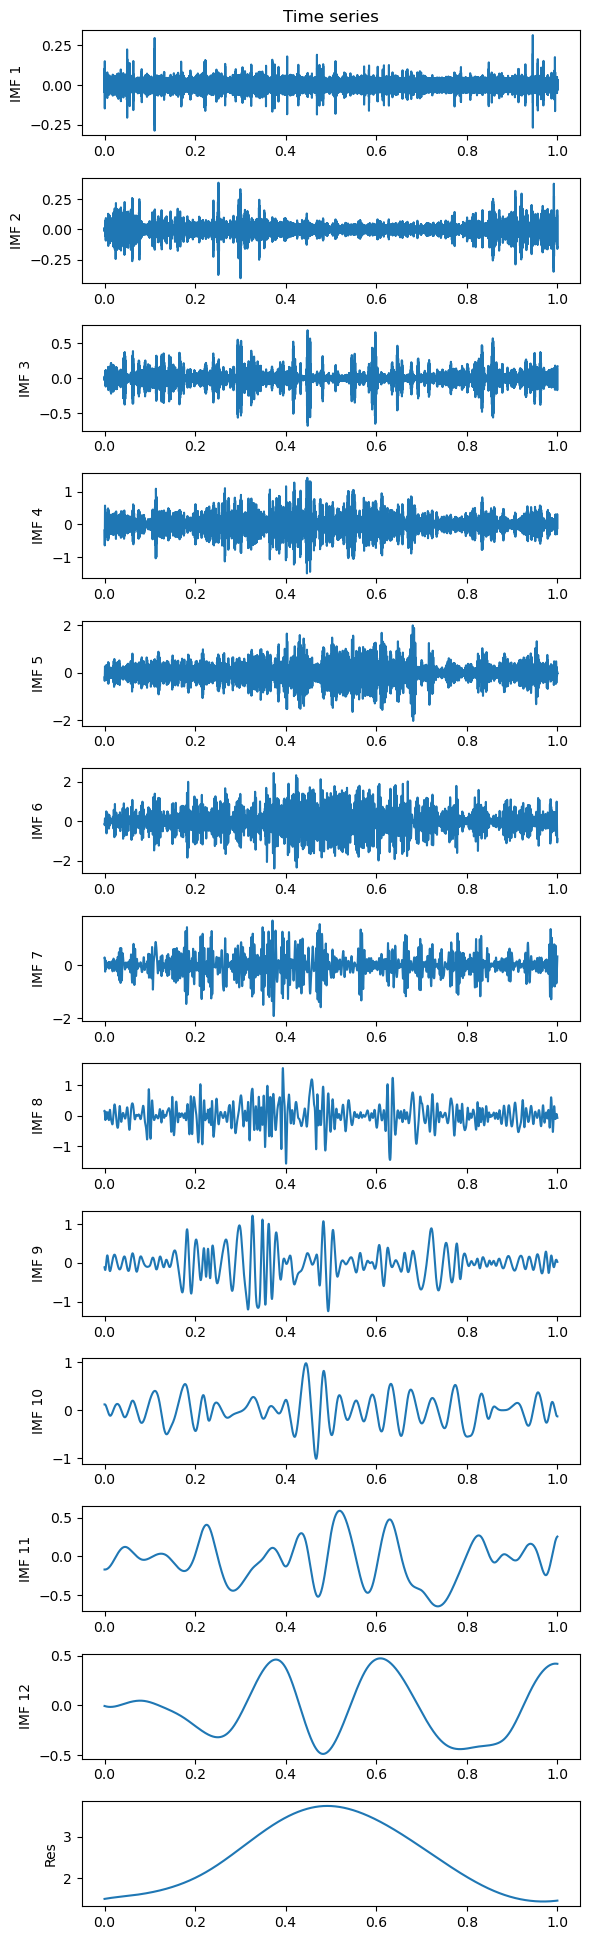

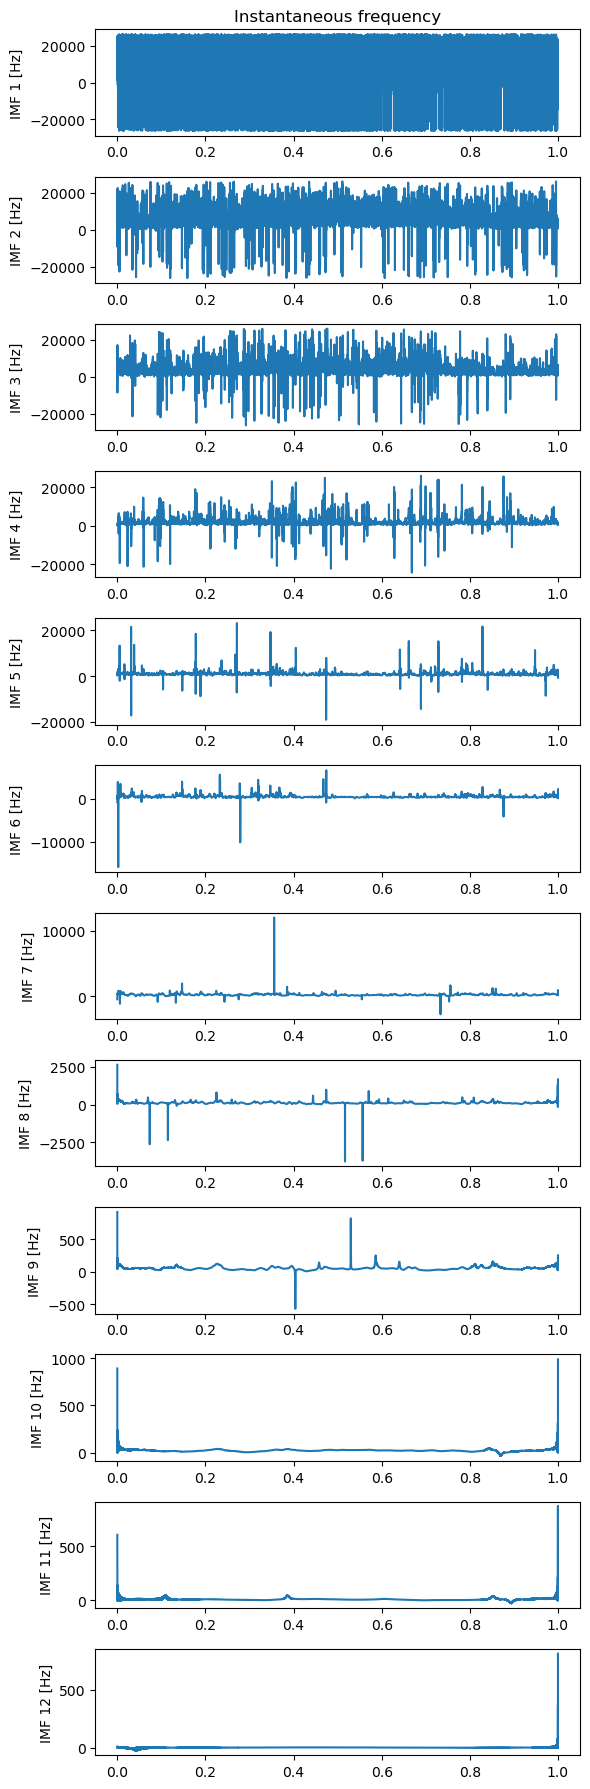

In [24]:

from PyEMD import EMD

import PyEMD;
print(PyEMD.__version__)
from pandas import read_csv


emd = EMD()

signal=data
t = np.linspace(0, 1, 52560)
from PyEMD import EMD, Visualisation

emd.emd(data)


imfs, res = emd.get_imfs_and_residue()

vis = Visualisation()

vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
vis.plot_instant_freq(t, imfs=imfs)
vis.show()



 IMF plots:

Below the time series plot, there are six individual plots labeled IMF1, IMF2, ..., IMF6. These are the Intrinsic Mode Functions (IMFs) extracted from the original signal using EMD. Each IMF represents a different frequency component of the data.

IMF1: This appears to be the highest-frequency IMF, with relatively fast oscillations. It might capture rapid changes or noise in the original signal.
IMF2-IMF4: These IMFs exhibit lower frequencies compared to IMF1. They might capture slower oscillations or periodic variations in the data.
IMF5-IMF6: These are the lowest-frequency IMFs, showing smooth trends or baseline variations in the signal.
3. Residue plot:

The bottom plot shows the residue after extracting the IMFs. This represents any remaining trend or slowly varying component that EMD couldn't decompose into IMFs. In your case, the residue seems relatively small, suggesting that the IMFs effectively captured most of the signal's components.

4. Instantaneous Frequency plot:

The rightmost plot shows the instantaneous frequency of each IMF over time. This reveals how the dominant frequencies within each IMF change throughout the signal. For example, in IMF2, we can see a gradual increase in frequency, indicating that the underlying oscillation is accelerating.

Overall interpretation:

This EMD analysis suggests that your signal contains multiple frequency components ranging from high-frequency noise to slower oscillations and long-term trends. The IMFs effectively separate these components, making it easier to analyze their individual characteristics and contributions to the overall signal behavior. The instantaneous frequency plot provides further insights into how the dominant frequencies within each IMF evolve over time.

In summary, the EMD analysis has helped you decompose your complex signal into simpler components, providing a deeper understanding of its underlying structure and dynamics.

I hope this explanation helps! Let me know if you have any further questions about the specific features you see in the plots or how EMD can be used for your data analysis.

In [26]:
imfs[0]

array([ 0.04046629, -0.04040889, -0.01501721, ...,  0.02342367,
        0.03560569,  0.03089597])

In [31]:
data

array([1.3, 1.2, 1.2, ..., 1.3, 1.3, 1.3])

In [32]:
two_d_array = data.reshape(-1, 1)


In [33]:
# Set the number of time steps for the LSTM
time_steps = 10

# Prepare the data for LSTM
def create_lstm_dataset(data, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_steps):
        a = data[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(data[i + time_steps, :])
    return np.array(dataX), np.array(dataY)

In [34]:
create_lstm_dataset(two_d_array)

(array([[[1.3]],
 
        [[1.2]],
 
        [[1.2]],
 
        ...,
 
        [[1.3]],
 
        [[1.3]],
 
        [[1.3]]]),
 array([[1.2],
        [1.2],
        [1.2],
        ...,
        [1.3],
        [1.3],
        [1.3]]))